In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

import os
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns

dir_path = "../data/"

In [2]:
train_val = pd.read_csv(dir_path + "ps6_trainvalid.csv")
test = pd.read_csv(dir_path + "ps6_test.csv")

# Preprocessing

In [3]:
train_val.isnull().sum()

datetime            0
temperature         3
humidity          152
pressure          252
weather             1
wind_direction      1
wind_speed          1
dtype: int64

In [4]:
train_val[train_val["temperature"].isnull()]

,datetime,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3859,2013-03-11 07:00:00,NaN,12.0,1036.0,sky is clear,4.0,0.0
3860,2013-03-11 08:00:00,NaN,24.0,1036.0,sky is clear,9.0,1.0


In [5]:
train_val.wind_speed.value_counts()

1.0     17646
0.0     15582
2.0      5237
3.0      2682
4.0      1867
5.0      1263
6.0       456
7.0       156
8.0        54
9.0        29
10.0       14
11.0       11
12.0        4
16.0        4
15.0        2
13.0        2
14.0        2
17.0        1
Name: wind_speed, dtype: int64

In [6]:
train_val.wind_direction.value_counts()

0.0      6887
230.0    2119
260.0    1451
250.0    1422
270.0    1243
         ... 
303.0      11
358.0      11
341.0      10
289.0      10
302.0       9
Name: wind_direction, Length: 361, dtype: int64

## fill NAN with interpolation

In [7]:
train_val = train_val.interpolate(method='linear', limit_direction='forward', axis=0)
train_val = train_val.drop(0)

In [8]:
train_val.isnull().sum()

datetime          0
temperature       0
humidity          0
pressure          0
weather           0
wind_direction    0
wind_speed        0
dtype: int64

In [9]:
test.isnull().sum()

datetime          0
temperature       0
humidity          0
pressure          0
weather           0
wind_direction    0
wind_speed        0
dtype: int64

## Date, Time

In [10]:
train_val["datetime"] = pd.to_datetime(train_val["datetime"], format = "%Y-%m-%d %H:%M:%S")
test["datetime"] = pd.to_datetime(test["datetime"], format = "%Y-%m-%d %H:%M:%S")


date_time = train_val["datetime"]
date_time_test = test["datetime"]

timestamp_s = date_time.map(datetime.datetime.timestamp)
timestamp_s_test = date_time_test.map(datetime.datetime.timestamp)


day = 24*60*60
year = (365.2425)*day

train_val['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_val['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_val['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_val['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

test['Day sin'] = np.sin(timestamp_s_test * (2 * np.pi / day))
test['Day cos'] = np.cos(timestamp_s_test * (2 * np.pi / day))
test['Year sin'] = np.sin(timestamp_s_test * (2 * np.pi / year))
test['Year cos'] = np.cos(timestamp_s_test * (2 * np.pi / year))




In [11]:
date_time = train_val["datetime"]

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [13]:
day = 24*60*60
year = (365.2425)*day

train_val['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_val['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_val['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_val['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

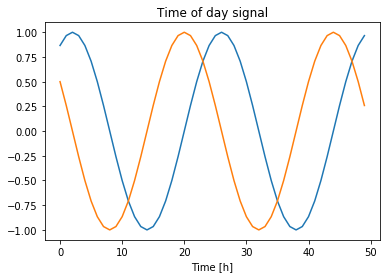

In [14]:
plt.plot(np.array(train_val['Day sin'])[:50])
plt.plot(np.array(train_val['Day cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [15]:
train_val = train_val.drop("datetime", axis = 1)
test = test.drop("datetime", axis = 1)

## Weather

In [16]:
train_val["weather"].value_counts()

sky is clear                    25983
haze                             3490
mist                             2938
broken clouds                    2564
overcast clouds                  2432
scattered clouds                 2266
light rain                       1946
few clouds                       1754
fog                               560
moderate rain                     481
smoke                             203
heavy intensity rain              127
light intensity drizzle           102
dust                               64
proximity thunderstorm             25
very heavy rain                    20
thunderstorm                       17
thunderstorm with light rain       13
shower rain                         8
drizzle                             5
proximity shower rain               4
light intensity shower rain         3
squalls                             3
thunderstorm with heavy rain        2
thunderstorm with rain              2
Name: weather, dtype: int64

In [17]:
test["weather"].value_counts()

sky is clear               153
haze                        42
mist                        23
fog                          6
scattered clouds             5
few clouds                   3
light rain                   3
light intensity drizzle      2
dust                         2
broken clouds                1
Name: weather, dtype: int64

In [18]:
def clear (x):
    if x =="sky is clear":
        return 1
    else:
        return 0

def haze (x):
    if x == "drizzle" or x == "light intensity drizzle":
        return 3
    if x == "fog":
        return 2
    elif x == "haze" or x == "mist":
        return 1
    else:
        return 0
    
def cloud(x):
    if x == "broken clouds" or x == "scattered clouds" or x == "few clouds" or x == "squalls":
        return 1
    elif x == "overcast clouds":
        return 2
    else:
        return 0
    
def rain(x):
    if x == "light rain" or x == "drizzle" or x == "light intensity drizzle" or x == "light intensity shower rain" or x == "thunderstorm with light rain":
        return 1
    elif x == "moderate rain" or x == "shower rain" or x == "proximity shower rain" or x == "thunderstorm with rain":
        return 2
    
    elif x == "heavy intensity rain" or x == "thunderstorm with heavy rain":
        return 3
    elif x == "very heavy rain":
        return 4
    else:
        return 0

def dust(x):
    if x == "smoke":
        return 2
    if x =="dust":
        return 1
    else:
        return 0
    
def thunderstorm(x):
    if x == "thunderstorm" or x == "thunderstorm with light rain" or x == "thunderstorm with rain" or x =="thunderstorm with heavy rain" or x == "proximity thunderstorm":
        return 1
    else: 
        return 0


In [19]:
train_val["clear"] = train_val["weather"].apply(clear)
train_val["haze"] = train_val["weather"].apply(haze)
train_val["cloud"] = train_val["weather"].apply(cloud)
train_val["rain"] = train_val["weather"].apply(rain)
train_val["dust"] = train_val["weather"].apply(dust)
train_val["thunderstorm"] = train_val["weather"].apply(thunderstorm)

test["clear"] = test["weather"].apply(clear)
test["haze"] = test["weather"].apply(haze)
test["cloud"] = test["weather"].apply(cloud)
test["rain"] = test["weather"].apply(rain)
test["dust"] = test["weather"].apply(dust)
test["thunderstorm"] = test["weather"].apply(thunderstorm)


In [20]:
del train_val["weather"]
del test["weather"]

In [21]:
##### train_val_test.to_csv(dir_path+"preprocessed_train_val_test.csv")
train_val.to_csv(dir_path+"preprocessed_train_val.csv")
test.to_csv(dir_path + "preprocessed_test.csv")

# Visualization

In [22]:
train_val = pd.read_csv(dir_path+"preprocessed_train_val.csv", header=0, index_col=0)
test = pd.read_csv(dir_path+"preprocessed_test.csv", header=0, index_col=0)

In [23]:
train_val.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,45012.0,290.841207,6.465209,266.503667,286.370000,2.905300e+02,295.080000,315.47
humidity,45012.0,62.733504,21.840257,5.000000,48.000000,6.600000e+01,81.000000,100.00
pressure,45012.0,1015.875211,11.500143,886.000000,1013.000000,1.016000e+03,1021.000000,1044.00
wind_direction,45012.0,139.733804,105.545576,0.000000,29.000000,1.400000e+02,230.000000,360.00
wind_speed,45012.0,1.220652,1.435687,0.000000,0.000000,1.000000e+00,2.000000,17.00
Day sin,45012.0,0.000104,0.707115,-1.000000,-0.707107,1.421321e-14,0.707107,1.00
Day cos,45012.0,-0.000135,0.707115,-1.000000,-0.707107,-8.736254e-15,0.707107,1.00
Year sin,45012.0,-0.023237,0.712145,-1.000000,-0.742946,-4.237423e-02,0.691941,1.00
Year cos,45012.0,0.010501,0.701585,-1.000000,-0.691948,3.857124e-02,0.697438,1.00
clear,45012.0,0.577246,0.494002,0.000000,0.000000,1.000000e+00,1.000000,1.00


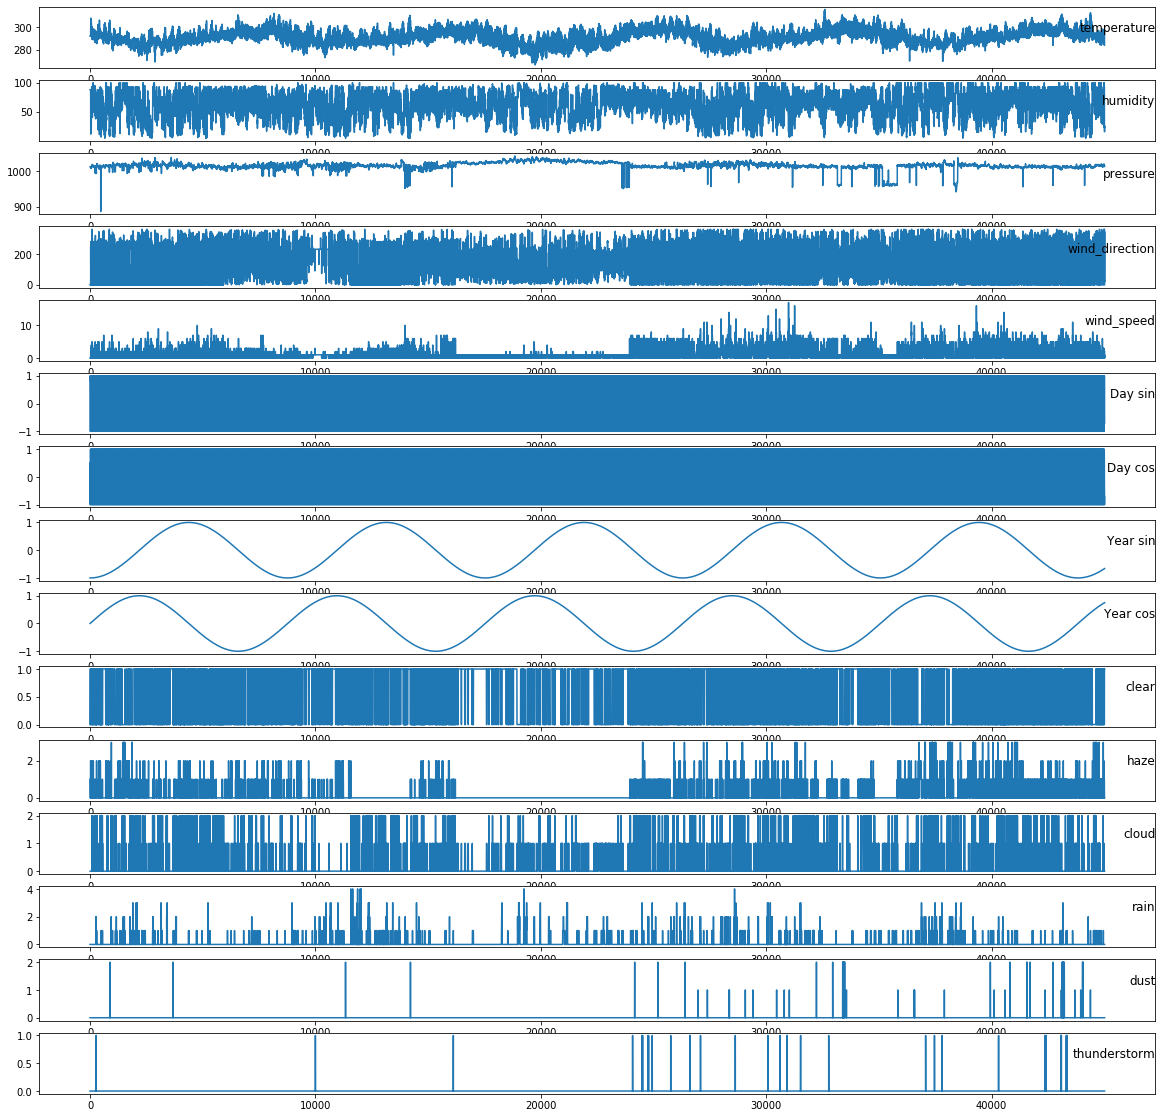

In [24]:
values = train_val.values
# specify columns to plot
groups = range(15)
i = 1
# plot each column
plt.figure(figsize=(20, 20))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(train_val.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Train Val Test Split

In [25]:
n = len(train_val)
train_df = train_val[0:int(n*0.8)]
val_df = train_val[int(n*0.8):]
test_df = test
num_features = train_val.shape[1]

# Normalization

In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Baseline Model(Linear Regression)

### predicting temperature after 24 hours

In [27]:
## train set contains temperature, humidity and pressure of previous 24 hours

tmp = train_df[["temperature","humidity","pressure"]]

train_base = pd.concat([tmp.shift(i).rename(columns = {"temperature" : "temperature "+str(i), "humidity" : "humidity "+str(i), "pressure" : "pressure " + str(i)}) for i in range(24)], axis=1).iloc[24::24,::]

train_base["target"] = train_base.iloc[:,0].shift(-1)

train_base = train_base.iloc[:-1,:]

In [28]:
## train X, y
X = train_base.iloc[:,:-1]
y = train_base.iloc[:,-1]

In [29]:
reg = LinearRegression().fit(X, y)

In [30]:
tmp = test_df[["temperature","humidity","pressure"]]

test_base = pd.concat([tmp.shift(i).rename(columns = {"temperature" : "temperature "+str(i), "humidity" : "humidity "+str(i), "pressure" : "pressure " + str(i)}) for i in range(24)], axis=1).iloc[24::24,::]

test_base["target"] = test_base.iloc[:,0].shift(-1)

test_base = test_base.iloc[:-1,:]

In [31]:
## test X, y
test_X = test_base.iloc[:,:-1]
test_y = test_base.iloc[:,-1]

In [32]:
test_X

,temperature 0,humidity 0,pressure 0,temperature 1,humidity 1,pressure 1,temperature 2,humidity 2,pressure 2,temperature 3,...,pressure 20,temperature 21,humidity 21,pressure 21,temperature 22,humidity 22,pressure 22,temperature 23,humidity 23,pressure 23
24,0.621246,-1.226380,-0.115600,0.722909,-2.421527,0.135348,0.860988,-0.720740,-0.115600,0.766912,...,-0.031951,-0.087359,0.474407,-0.031951,0.006717,-1.686052,-0.031951,0.349639,-1.456216,-0.199249
48,1.490691,-1.823953,-0.031951,1.583250,-1.823953,-0.031951,1.642427,-1.869920,-0.031951,1.772919,...,-0.031951,0.011269,-1.456216,0.051698,0.188800,-1.272347,-0.031951,0.367848,-0.628806,-0.031951
72,2.021766,-2.053789,-0.115600,2.247852,-2.099757,-0.115600,2.398070,-2.283625,-0.115600,2.341928,...,0.051698,0.548413,-0.858642,-0.031951,0.794225,-1.318314,-0.031951,1.091627,0.474407,-0.031951
96,1.734985,-1.777986,-0.115600,2.064252,-1.915888,-0.282898,2.126463,-1.869920,-0.282898,2.150741,...,-0.031951,0.906509,-1.961855,0.218997,1.235775,-1.594117,0.218997,1.537729,-1.823953,-0.031951
120,1.307091,-1.042511,-0.450196,1.527108,-1.180412,-0.450196,1.599941,-1.364281,-0.450196,1.610562,...,-0.282898,0.669802,-0.720740,-0.282898,0.964169,-0.996543,-0.282898,1.279779,-1.594117,-0.282898
144,0.932304,1.761489,-0.031951,1.155355,-0.904609,-0.115600,1.338956,-1.456216,-0.115600,1.378407,...,-0.366547,0.457372,-0.444937,-0.366547,0.671319,-0.398970,-0.450196,0.959617,-0.674773,-0.450196
168,0.326879,0.934079,-0.031951,0.531722,0.474407,-0.031951,0.648559,0.106670,-0.031951,0.631868,...,0.135348,0.085620,1.439719,0.135348,0.200939,1.761489,0.051698,0.487719,1.761489,-0.031951
192,0.082585,0.060702,-0.199249,0.194869,-1.686052,-0.115600,0.172109,-0.766707,-0.199249,0.102310,...,-0.031951,-0.287650,0.934079,-0.031951,-0.158675,1.163915,-0.031951,0.012786,0.934079,-0.031951


In [33]:
pred = reg.predict(test_X)

In [34]:
print("Performance(mae) :", sum(abs(pred-test_y))/len(pred))

Performance(mae) : 0.9962700775963549


Feature: temperature 0, Score: 0.14770
Feature: humidity 0, Score: -0.01251
Feature: pressure 0, Score: -0.09821
Feature: temperature 1, Score: 0.50333
Feature: humidity 1, Score: 0.00706
Feature: pressure 1, Score: 0.05519
Feature: temperature 2, Score: -0.05398
Feature: humidity 2, Score: -0.00345
Feature: pressure 2, Score: -0.02085
Feature: temperature 3, Score: -0.06975
Feature: humidity 3, Score: -0.00491
Feature: pressure 3, Score: -0.01792
Feature: temperature 4, Score: 0.11989
Feature: humidity 4, Score: 0.04363
Feature: pressure 4, Score: 0.09556
Feature: temperature 5, Score: -0.05789
Feature: humidity 5, Score: -0.01741
Feature: pressure 5, Score: -0.05457
Feature: temperature 6, Score: -0.06136
Feature: humidity 6, Score: 0.02863
Feature: pressure 6, Score: 0.03249
Feature: temperature 7, Score: 0.13733
Feature: humidity 7, Score: -0.00776
Feature: pressure 7, Score: 0.02303
Feature: temperature 8, Score: -0.10982
Feature: humidity 8, Score: -0.00204
Feature: pressure 8, S

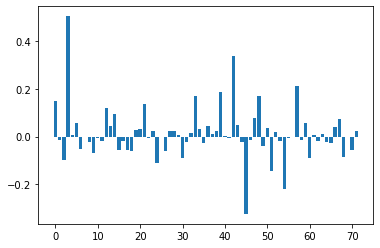

In [35]:
## feature importance
importance = reg.coef_
a = list(train_base.columns)*24
# summarize feature importance
importance_dict = dict()
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (a[i],v))
    importance_dict[a[i]] = v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [36]:
sorted(list(importance_dict.items()), key = lambda x : -abs(x[1]))

[('temperature 1', 0.5033259893548194),
 ('temperature 14', 0.3388233932333411),
 ('temperature 15', -0.3238918190877497),
 ('temperature 18', -0.22032815940242423),
 ('temperature 19', 0.21319524016601907),
 ('temperature 13', 0.18805639851213013),
 ('temperature 16', 0.17096951101751548),
 ('temperature 11', 0.16878792076376295),
 ('temperature 0', 0.1477025092227703),
 ('temperature 17', -0.1458521259411389),
 ('temperature 7', 0.13732843860144212),
 ('temperature 4', 0.11988916923234702),
 ('temperature 8', -0.1098206374506196),
 ('pressure 0', -0.09820597356804675),
 ('pressure 4', 0.09556270004635091),
 ('temperature 10', -0.09144379920129372),
 ('temperature 20', -0.0900323520690493),
 ('pressure 22', -0.085278313320789),
 ('pressure 15', 0.0765786768681814),
 ('humidity 22', 0.0728004297678356),
 ('temperature 3', -0.06975090161608363),
 ('pressure 8', -0.0616133422264369),
 ('temperature 6', -0.06136292869783669),
 ('humidity 23', -0.058000576553159294),
 ('temperature 5', -0.

In [37]:
column_indices = {name: i for i, name in enumerate(train_val.columns)}

In [38]:
column_indices

{'temperature': 0,
 'humidity': 1,
 'pressure': 2,
 'wind_direction': 3,
 'wind_speed': 4,
 'Day sin': 5,
 'Day cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'clear': 9,
 'haze': 10,
 'cloud': 11,
 'rain': 12,
 'dust': 13,
 'thunderstorm': 14}

# Windowing Data

In [39]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

          # Slicing doesn't preserve static shape information, so set the shapes
          # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def plot(self, model=None, plot_col='temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2, MAX_EPOCHS = 20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [41]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])
w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temperature']

In [42]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 15)
Inputs shape: (3, 24, 15)
labels shape: (3, 1, 1)


# Baseline model for single shot

## just copies temperature of previous 24 hours 

In [43]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [44]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [45]:
baseline = Baseline(label_index=column_indices['temperature'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

282/282 [==============================] - 1s 3ms/step - loss: 0.0341 - mean_absolute_error: 0.1261


In [46]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    label_columns=['temperature'])

wide_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['temperature']

In [47]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 15)
Output shape: (32, 1, 1)


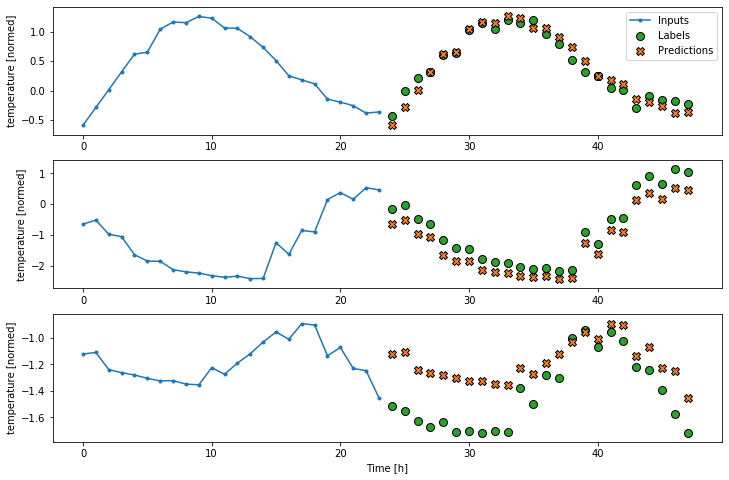

In [48]:
wide_window.plot(baseline)

# Linear model

## Using Dense layere without activation

In [49]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [50]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 15)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1126/1126 [==============================] - 5s 4ms/step - loss: 0.9390 - mean_absolute_error: 0.7003 - val_loss: 0.0545 - val_mean_absolute_error: 0.1639
Epoch 2/20
1126/1126 [==============================] - 4s 4ms/step - loss: 0.0541 - mean_absolute_error: 0.1653 - val_loss: 0.0220 - val_mean_absolute_error: 0.1088
Epoch 3/20
1126/1126 [==============================] - 4s 4ms/step - loss: 0.0443 - mean_absolute_error: 0.1427 - val_loss: 0.0199 - val_mean_absolute_error: 0.1032
Epoch 4/20
1126/1126 [==============================] - 4s 4ms/step - loss: 0.0436 - mean_absolute_error: 0.1399 - val_loss: 0.0199 - val_mean_absolute_error: 0.1031
Epoch 5/20
1126/1126 [==============================] - 4s 4ms/step - loss: 0.0437 - mean_absolute_error: 0.1398 - val_loss: 0.0201 - val_mean_absolute_error: 0.1038
Epoch 6/20
282/282 [==============================] - 1s 3ms/step - loss: 0.0201 - mean_absolute_error: 0.1038


In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


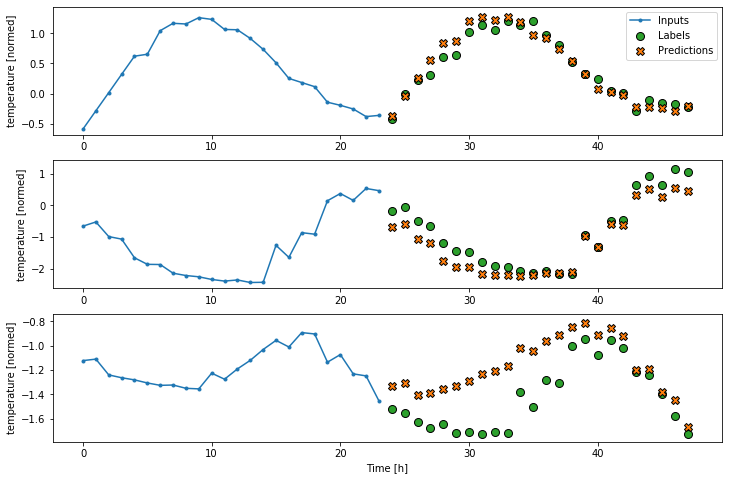

In [53]:
wide_window.plot(linear)

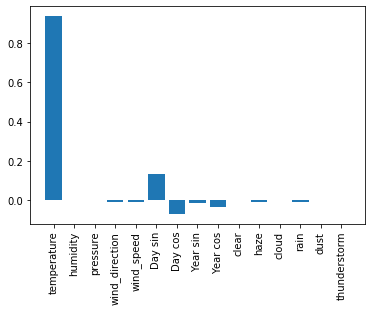

In [54]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Multi Step Labels

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

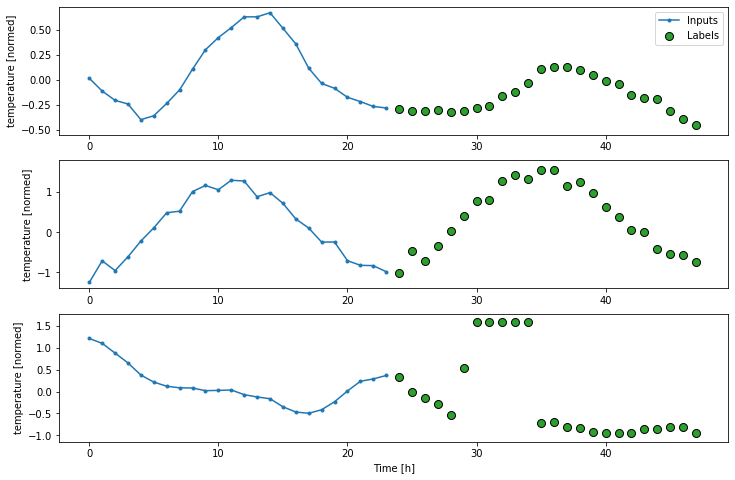

In [55]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Multi Step BaseLine ( keeping the last temperature)

280/280 [==============================] - 1s 3ms/step - loss: 1.9258 - mean_absolute_error: 0.6094


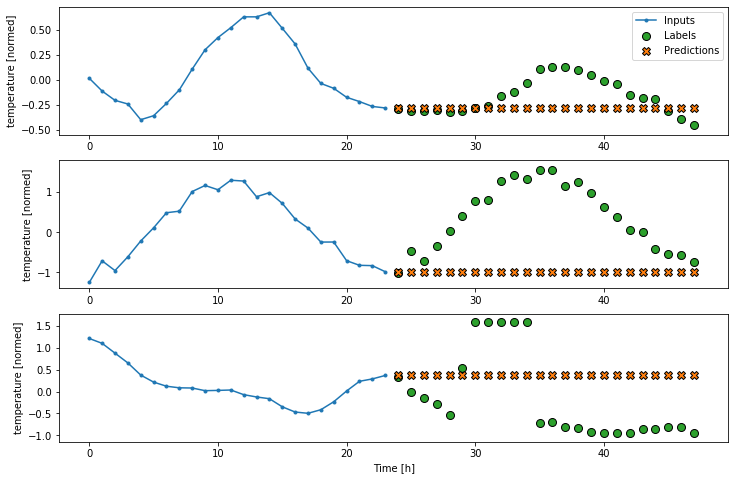

In [56]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

# Repeat Baseline (Repeating previouse 24 hour temperature)

280/280 [==============================] - 1s 3ms/step - loss: 1.5394 - mean_absolute_error: 0.3847


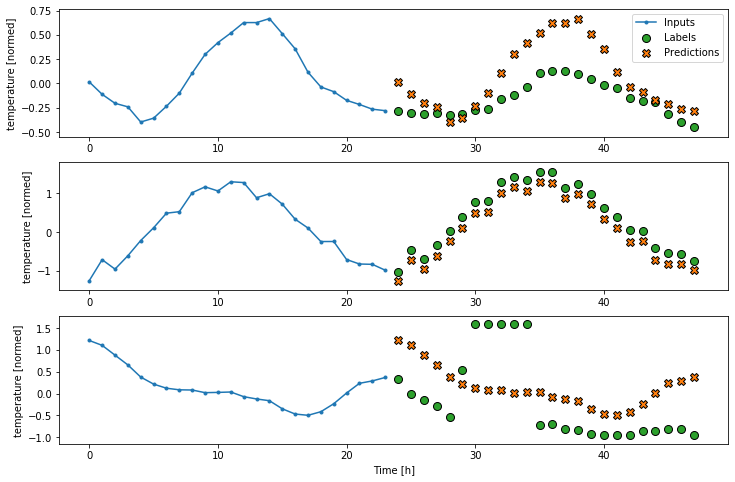

In [57]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Linear Model

280/280 [==============================] - 1s 3ms/step - loss: 0.9216 - mean_absolute_error: 0.3958


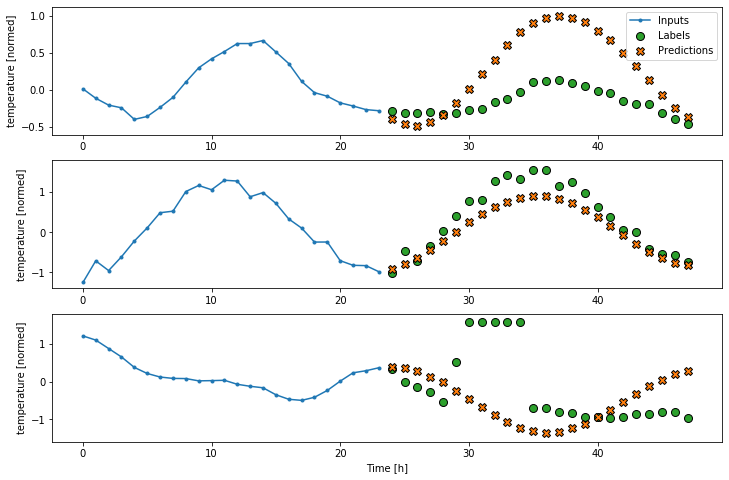

In [58]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Dense Model Ising Relu Activation Function

280/280 [==============================] - 1s 3ms/step - loss: 0.9239 - mean_absolute_error: 0.3995


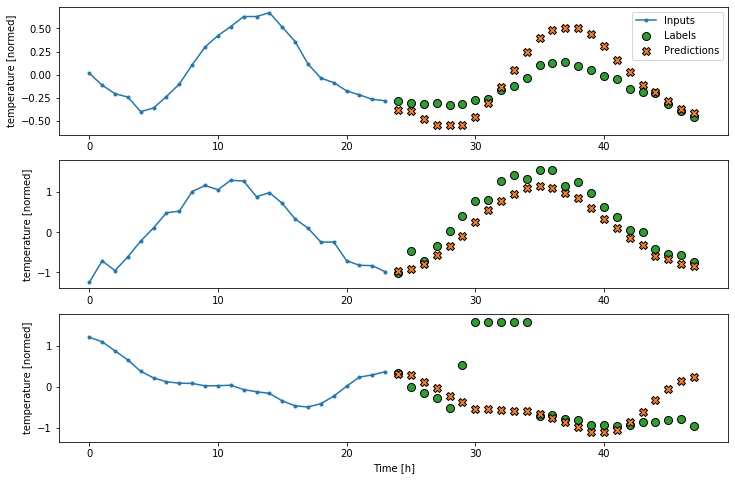

In [59]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# Convolutional model using Conv1D

280/280 [==============================] - 1s 3ms/step - loss: 0.8817 - mean_absolute_error: 0.4032


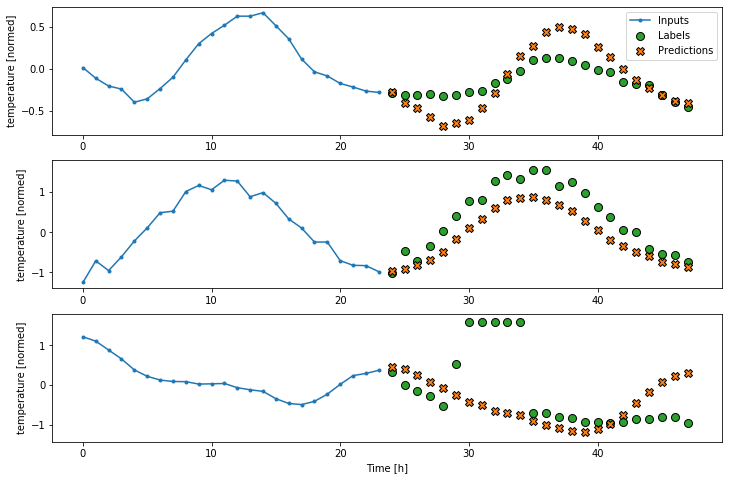

In [60]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# LSTM model

280/280 [==============================] - 1s 5ms/step - loss: 0.8667 - mean_absolute_error: 0.4086


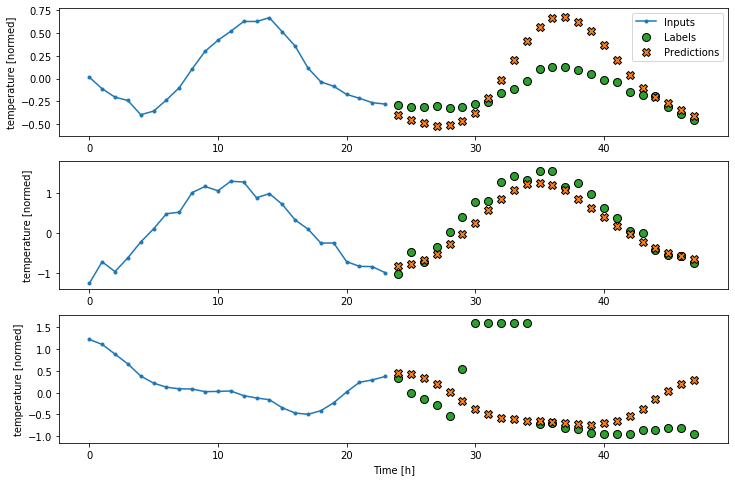

In [61]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Self FeedBack Model

In [62]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [63]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [64]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [65]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 15])

In [66]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call



In [67]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 15)


280/280 [==============================] - 2s 6ms/step - loss: 0.8922 - mean_absolute_error: 0.4183


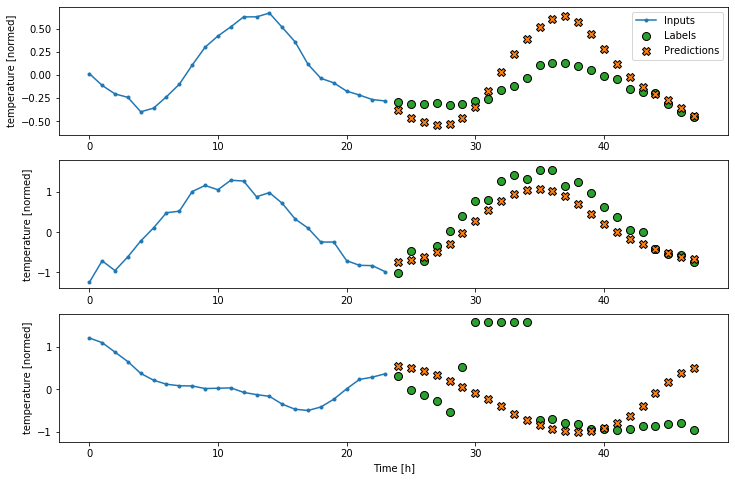

In [68]:
history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS = 50)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Model Result

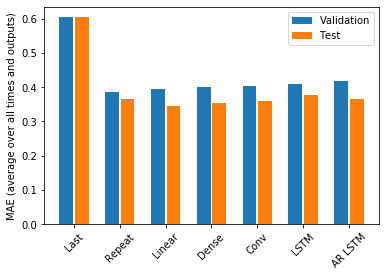

In [69]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [70]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.6050
Repeat  : 0.3657
Linear  : 0.3464
Dense   : 0.3548
Conv    : 0.3599
LSTM    : 0.3765
AR LSTM : 0.3651


In [71]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.6050
Repeat  : 0.3657
Linear  : 0.3464
Dense   : 0.3548
Conv    : 0.3599
LSTM    : 0.3765
AR LSTM : 0.3651


In [72]:
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

In [73]:
val_mae

[0.604986310005188,
 0.3863140940666199,
 0.3957986533641815,
 0.3994966447353363,
 0.4031813442707062,
 0.40864717960357666,
 0.41833075881004333]

In [74]:
test_mae

[0.6049861907958984,
 0.365740031003952,
 0.34644612669944763,
 0.3547542989253998,
 0.3599352240562439,
 0.37648633122444153,
 0.3650943636894226]